In [100]:
import numpy as np
import pandas as pd
import faiss
from sklearn.preprocessing import StandardScaler

In [101]:
base = pd.read_csv('data/base.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [102]:
train.head()

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [103]:
train_merge = train.merge(base, left_on = 'Target', right_on='Id').drop(columns = {'Id_x', "Id_y", 'Target'})

In [104]:
diff = np.array(train_merge)[:,:72] - np.array(train_merge)[:,72:]

In [105]:
sq = np.squeeze(diff)

In [106]:
sq.shape

(100000, 72)

In [107]:
df = pd.DataFrame(sq, columns = [*range(0, sq.shape[1])])

Посмотрим гисторграммы разницы для каждого фича:

<AxesSubplot:>

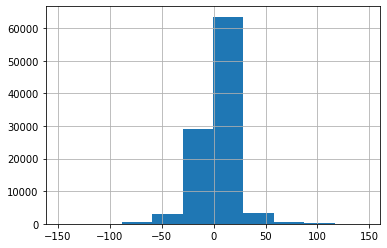

In [108]:
df.iloc[:, 20].hist()

Отберем те, у которых норм распределение по разнице в 0:

In [109]:

idx = [0, 3, 6, 8, 12, 13, 14, 17, 20, 22, 24, 26, 27, 28, 30, 31, 32, 33, 35, 39, 40, 42, 43, 47, 49, 52, 54, 58, 61, 65, 68, 70]

Заскелим

In [110]:
sc = StandardScaler().fit(base.iloc[:,1:])
base.iloc[:,1:] = sc.transform(base.iloc[:,1:])
test.iloc[:,1:] = sc.transform(test.iloc[:,1:])

In [111]:
base = base.iloc[:,[0, 3, 6, 8, 12, 13, 14, 17, 20, 22, 24, 26, 27, 28, 30, 31, 32, 33, 35, 39, 40, 42, 43, 47, 49, 52, 54, 58, 61, 65, 68, 70]]
test = test.iloc[:,[0, 3, 6, 8, 12, 13, 14, 17, 20, 22, 24, 26, 27, 28, 30, 31, 32, 33, 35, 39, 40, 42, 43, 47, 49, 52, 54, 58, 61, 65, 68, 70]]

Найдем ближние

In [112]:
model_columns = base.columns[1:]
d = len(model_columns)                          # dimension
nb = base.shape[0]                     # database size
nq = test.shape[0]                 # nb of queries
np.random.seed(134)             # make reproducible

# xb = np.ascontiguousarray(base[model_columns].values).astype('float32')
xb = np.array(base[model_columns].values).astype('float32')
xq = np.array(test[model_columns].values).astype('float32')

nlist = 1
k = 10
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained
index.add(xb)


In [113]:
index.nprobe = 1
D, I = index.search(xq, k)

Формируем таблицу с ответом

In [115]:
#из таблицы I с индексами кандидатов формируем строку в формате ответа
id_base_dict = dict(base['Id'])

predicted_list = []
for candidates in I:
    predicted_list.append(' '.join([id_base_dict[candidate] for candidate in candidates]))
    
#формируем ответ
baseline_answer = test[['Id']]
baseline_answer['Predicted'] = predicted_list

baseline_answer.to_csv('submission.csv', index=False)

C:\Users\Lampq\AppData\Local\Temp\ipykernel_17248\1006977022.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_answer['Predicted'] = predicted_list
